# Player & Team Recognition Assignment

Dom Dathan

In [1]:
# imports
import numpy as np
import os
import random

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# image handling
from PIL import Image

# plotting
import matplotlib.pyplot as plt
%matplotlib inline



Define Classes that will be used:

PlayerTilesDataset is a dataset class for the images to be loaded into the model easily

In [2]:
class PlayerTilesDataset(Dataset):
    """Image Loader dataset for player tiles."""
    def __init__(self, dirname, transform=None):
        """
        Args:
            root (string): Path to the images organized in a team\player\image.jpg format.
            transform: Any Pytorch transform to be applied
        """
        
        # initalise image paths
        self.image_paths = []
        
        # initialse image labels - one for team and one for player
        self.labels1 = []
        self.labels2 = []
        
        # get all team folders
        teams = [f.name for f in os.scandir(dirname) if f.is_dir()]

        # iterate over each team folder
        for team in list(teams):

            # create team directory
            teams_dir = os.path.join(dirname,team)

            # get all players for that team
            players = [f.name for f in os.scandir(teams_dir) if f.is_dir()]

            # iterate over each player
            for player in list(players):

                # create player directory
                player_dir = os.path.join(dirname,team,player)

                # get all images for that player
                images = [f.name for f in os.scandir(player_dir)]

                # iterate over all images
                for image in images:

                    # append image path
                    self.image_paths.append(os.path.join(dirname,team,player,image))
                    
                    # append labels
                    self.labels1.append(team)
                    self.labels2.append(team+'_'+player)

        # Create a dictionary mapping each label to a index from 0 to len(classes) for both outputs
        self.label1_to_idx = {x:i for i,x in enumerate(set(self.labels1))}
        self.label2_to_idx = {x:i for i,x in enumerate(set(self.labels2))}
        
        # Create a dictionary mapping each index to corresponding label for both outputs
        self.idx_to_label1 = {ind: label for label, ind in self.label1_to_idx.items()}
        self.idx_to_label2 = {ind: label for label, ind in self.label2_to_idx.items()}
        
        # transform if requessted
        self.transform = transform
        
    def __len__(self):
        # return length of dataset
        return len(self.image_paths)
      
    def __getitem__(self, idx):
        # open and send one image and label
        
        # get image path
        img_name = self.image_paths[idx]
        
        # get image labels
        label1 = self.labels1[idx] # team
        label2 = self.labels2[idx] # player
        
        # open image
        image = Image.open(img_name)
        
        # transform if requested
        if self.transform:
            image = self.transform(image)
            
        return image,self.label1_to_idx[label1],self.label2_to_idx[label2]

Net class is a class for the neural network
Since this is an image prediction problem a CNN is chosen
The modeule returns two outputs - one for the team prediction and one for the person prediction

In [3]:
class Net(nn.Module):
    "Pytorch neural network model class"
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 56 * 56, 84)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
        self.fc4 = nn.Linear(84,54)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1,8 * 56 * 56)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x1 = self.fc3(x)
        x2 = self.fc4(x)
        return x1, x2

In [4]:
# set directory of folder holding all images
imdir = 'part1'

# transform images to tensor
t = transforms.ToTensor()

# load dataset
train_dataset = PlayerTilesDataset(dirname=imdir,transform=t)

In [5]:
# set targets
targets = [team + '_' + player for team, player in zip(train_dataset.labels1, train_dataset.labels2)]

In [6]:
def get_target_counts(targets):
    # count instances of each class in targets
    return {target_class: targets.count(target_class) for target_class in set(targets)}


def print_target_counts(targets):
    target_counts = get_target_counts(targets)
    total_targets = 0
    print(len(target_counts))
    for target in target_counts:
        total_targets += target_counts[target]
    for target in target_counts:
        print('{} : {}, {:.1f}%'.format(target,target_counts[target],100*target_counts[target]/total_targets))
        
print('Number of instances in each class of WHOLE dataset:')
print_target_counts(targets)

Number of instances in each class of WHOLE dataset:
54
middlesbrough_middlesbrough_person_27 : 50, 1.9%
spal_team_a_spal_team_a_person_17 : 31, 1.2%
bristol_bristol_person_8 : 175, 6.6%
wigan_wigan_person_15 : 6, 0.2%
wigan_wigan_person_20 : 58, 2.2%
bristol_bristol_person_42 : 52, 2.0%
wigan_wigan_person_22 : 15, 0.6%
bristol_bristol_person_25 : 142, 5.4%
bristol_bristol_person_23 : 113, 4.3%
bristol_bristol_person_45 : 82, 3.1%
bristol_bristol_person_2 : 17, 0.6%
spal_team_a_spal_team_a_person_10 : 9, 0.3%
spal_team_a_spal_team_a_person_15 : 29, 1.1%
nottingham_forrest_nottingham_forrest_person_23 : 72, 2.7%
wigan_wigan_person_19 : 58, 2.2%
middlesbrough_middlesbrough_person_6 : 97, 3.7%
middlesbrough_middlesbrough_person_5 : 39, 1.5%
spal_team_a_spal_team_a_person_6 : 4, 0.2%
bristol_bristol_person_11 : 95, 3.6%
spal_team_a_spal_team_a_person_19 : 64, 2.4%
bristol_bristol_person_40 : 133, 5.0%
middlesbrough_middlesbrough_person_11 : 10, 0.4%
nottingham_forrest_nottingham_forrest_per

In [7]:
# Split data into train 70%, validation 20% and test 10%
# Use stratify to ensure equal weighting of each class
# First split into train and the rest
train_idx, rest_idx = train_test_split(np.arange(len(targets)),test_size=0.3, random_state=42, 
                                        shuffle=True, stratify=targets)
# set train targets and assign the targets of the remaining samples
train_targets = [targets[i] for i in train_idx]
rest_targets = [targets[i] for i in rest_idx]

# next split rest into validation and test
valid_idx, test_idx = train_test_split(np.arange(len(rest_targets)),test_size=0.33, random_state=42, 
                                        shuffle=True)

# refer valid_idx and test_idx back to rest_idx
valid_idx = rest_idx[valid_idx]
test_idx = rest_idx[test_idx]

# set validation and test target values
valid_targets = [targets[i] for i in valid_idx]
test_targets = [targets[i] for i in test_idx]

In [8]:
# Print some information
# First, number of training, validation and test samples
print("Number of training samples: ", len(train_idx))
print("Number of validation samples: ", len(valid_idx))
print("Number of test samples: ", len(test_idx))

# Print the number of instances in each set
# Each individual set has a similar proportion to the whole dataset as required
print('Number of instances in each class of TRAIN dataset:')
print_target_counts(train_targets)
print('\n')
print('Number of instances in each class of VALID dataset:')
print_target_counts(valid_targets)
print('\n')
print('Number of instances in each class of TEST dataset:')
print_target_counts(test_targets)

Number of training samples:  1845
Number of validation samples:  529
Number of test samples:  262
Number of instances in each class of TRAIN dataset:
54
middlesbrough_middlesbrough_person_27 : 35, 1.9%
spal_team_a_spal_team_a_person_17 : 22, 1.2%
bristol_bristol_person_8 : 123, 6.7%
wigan_wigan_person_20 : 41, 2.2%
wigan_wigan_person_15 : 4, 0.2%
bristol_bristol_person_42 : 36, 2.0%
wigan_wigan_person_22 : 11, 0.6%
bristol_bristol_person_25 : 99, 5.4%
bristol_bristol_person_23 : 79, 4.3%
bristol_bristol_person_45 : 57, 3.1%
bristol_bristol_person_2 : 12, 0.7%
spal_team_a_spal_team_a_person_15 : 20, 1.1%
spal_team_a_spal_team_a_person_10 : 6, 0.3%
nottingham_forrest_nottingham_forrest_person_23 : 50, 2.7%
wigan_wigan_person_19 : 41, 2.2%
middlesbrough_middlesbrough_person_6 : 68, 3.7%
middlesbrough_middlesbrough_person_5 : 27, 1.5%
spal_team_a_spal_team_a_person_6 : 3, 0.2%
nottingham_forrest_nottingham_forrest_person_18 : 6, 0.3%
bristol_bristol_person_11 : 67, 3.6%
spal_team_a_spal_te

In [9]:
# Set up train, validation and test dataloaders
# Train and validation are sampled randomly
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
# test is not sampled randomly so images can be iterated in order for visualisation
test_sampler = torch.utils.data.Subset(train_dataset,test_idx)

# train and validation have batch size set. test has batch size of 1 to process each image separately
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_sampler, batch_size=1, shuffle=False)

In [10]:
# function to return the correct number of predictions from predictions and labels
def get_num_correct(preds, labels):
    
    corr1 = preds[0].argmax(dim=1).eq(labels[0])
    corr2 = preds[1].argmax(dim=1).eq(labels[1])
    
    corr = torch.logical_and(corr1,corr2)
    
    return corr.sum().item()

# TRAIN MODEL

In [11]:
# initialise model
model = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10
# iterate over each epoch
for epoch in range(num_epochs):
    
    # initialise total loss and total_correct variables
    total_loss = 0
    total_correct = 0
    
    # set model to train mode
    model.train()
    
    # iterate over batches in training dataset
    for batch in train_loader: # Get Batch
        images, labels1, labels2 = batch 

        preds1, preds2 = model(images) # pass batch to model forward pass
        loss1 = F.cross_entropy(preds1, labels1) # calculate Loss
        loss2 = F.cross_entropy(preds2, labels2) # calculate Loss
        
        loss = loss1+loss2
        
        optimizer.zero_grad() # zero greadients
        loss.backward() # calculate Gradients
        optimizer.step() # update Weights

        total_loss += loss.item() # add loss to total loss
        total_correct += get_num_correct([preds1,preds2], [labels1,labels2]) # add prediction to total correct
    
    # set model to evaluate
    model.eval()
    
    # initialise total loss and total_correct for validation set
    val_total_loss = 0
    val_total_correct = 0
    
    # iterate over eatch batch in validation set
    for val_batch in valid_loader:
        val_images, val_labels1, val_labels2 = val_batch
        
        val_pred1, val_pred2 = model(val_images) # make predcitions
        val_loss1 = F.cross_entropy(val_pred1, val_labels1) # calculate losses
        val_loss2 = F.cross_entropy(val_pred2, val_labels2) # calculate losses
        
        val_loss = val_loss1 + val_loss2
        
        val_total_loss += val_loss.item() # add to total loss
        val_total_correct += get_num_correct([val_pred1,val_pred2],[val_labels1,val_labels2]) # add prediction to total correct
    
    # print epoch results
    print(
        'epoch: {},'.format(epoch), 
        'total_correct:{},'.format(total_correct), 
        'loss: {:.1f},'.format(total_loss),
        'validation_total_correct: {}'.format(val_total_correct),
        'validation_loss: {:.1f},'.format(val_total_loss)

    )

epoch: 0, total_correct:67, loss: 176.4, validation_total_correct: 34 validation_loss: 44.0,
epoch: 1, total_correct:204, loss: 122.6, validation_total_correct: 50 validation_loss: 34.5,
epoch: 2, total_correct:270, loss: 100.7, validation_total_correct: 125 validation_loss: 28.1,
epoch: 3, total_correct:493, loss: 79.9, validation_total_correct: 140 validation_loss: 24.8,
epoch: 4, total_correct:574, loss: 70.8, validation_total_correct: 158 validation_loss: 24.2,
epoch: 5, total_correct:709, loss: 61.9, validation_total_correct: 194 validation_loss: 19.3,
epoch: 6, total_correct:867, loss: 49.8, validation_total_correct: 205 validation_loss: 20.1,
epoch: 7, total_correct:967, loss: 44.4, validation_total_correct: 221 validation_loss: 18.9,
epoch: 8, total_correct:1085, loss: 39.3, validation_total_correct: 222 validation_loss: 20.2,
epoch: 9, total_correct:1180, loss: 35.5, validation_total_correct: 246 validation_loss: 21.8,


# EVALUATE MODEL

In [12]:
# initialise prediction and target variables for training, validation and test set
train_predictions = {'Team':[], 'Person':[]}
train_targets = {'Team':[], 'Person':[]}
val_predictions = {'Team':[], 'Person':[]}
val_targets = {'Team':[], 'Person':[]}
test_predictions = {'Team':[], 'Person':[]}
test_targets = {'Team':[], 'Person':[]}

# also initialise loss and total correct variables for test set
test_total_loss = 0
test_total_correct = 0
train_total_correct = 0
val_total_correct = 0

# iterate over each training batch
for batch in train_loader: # get batch
    train_images, train_labels1, train_labels2 = batch 
    train_preds1, train_preds2 = model(train_images) # get predictions for batch
    train_predictions['Team'].extend(train_preds1.argmax(dim=1)) # append predictions for team
    train_predictions['Person'].extend(train_preds2.argmax(dim=1)) # append predictions for person
    train_targets['Team'].extend(train_labels1) # append team truth
    train_targets['Person'].extend(train_labels2) # append person truth
  
    train_total_correct += get_num_correct([train_preds1,train_preds2], 
                                           [train_labels1,train_labels2])

# iterate over each validation batch
for batch in valid_loader: # get batch
    val_images, val_labels1, val_labels2 = batch 
    val_preds1, val_preds2 = model(val_images) # get predictions for batch
    val_predictions['Team'].extend(val_preds1.argmax(dim=1)) # append predictions for team
    val_predictions['Person'].extend(val_preds2.argmax(dim=1)) # append predictions for person  
    val_targets['Team'].extend(val_labels1) # append team truth
    val_targets['Person'].extend(val_labels2) # append person truth    
    val_total_correct += get_num_correct([val_preds1,val_preds2], 
                                           [val_labels1,val_labels2])

# iterate over each test sample
for test_image,test_label1, test_label2 in test_loader: # get sample
    test_pred1, test_pred2 = model(test_image) # get prediction
    test_predictions['Team'].extend(test_pred1.argmax(dim=1)) # append predictions for team
    test_predictions['Person'].extend(test_pred2.argmax(dim=1)) # append predictions for person  
    test_targets['Team'].extend(test_label1) # append team truth
    test_targets['Person'].extend(test_label2) # append person truth
    test_total_correct += get_num_correct([test_pred1,test_pred2], 
                                           [test_label1,test_label2])   
    test_loss1 = F.cross_entropy(test_pred1, test_label1) # calculate loss
    test_loss2 = F.cross_entropy(test_pred2, test_label2) # calculate loss
    test_total_loss += test_loss1.item()+test_loss2.item() # add loss

In [13]:
# convert predictions and ground truth targets from index to labels
train_predictions_labels = {'Team':[], 'Person':[]}
train_targets_labels = {'Team':[], 'Person':[]}
val_predictions_labels = {'Team':[], 'Person':[]}
val_targets_labels = {'Team':[], 'Person':[]}
test_predictions_labels = {'Team':[], 'Person':[]}
test_targets_labels = {'Team':[], 'Person':[]}

# training set
train_targets_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in train_targets['Team']]
train_targets_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in train_targets['Person']]
train_predictions_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in train_predictions['Team']]
train_predictions_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in train_predictions['Person']]

# validation set
val_predictions_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in val_predictions['Team']]
val_predictions_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in val_predictions['Person']]
val_targets_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in val_targets['Team']]
val_targets_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in val_targets['Person']]

# test set
test_predictions_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in test_predictions['Team']]
test_predictions_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in test_predictions['Person']]
test_targets_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in test_targets['Team']]
test_targets_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in test_targets['Person']]

In [14]:
# evaluate accuracy of training, validation and test set predictions
print('Training dataset accuracy: {:.1f}%'.format(100*train_total_correct/len(train_targets_labels['Team'])))
print('Validation dataset accuracy: {:.1f}%'.format(100*val_total_correct/len(val_targets_labels['Team'])))
print('Test dataset accuracy: {:.1f}%'.format(100*test_total_correct/len(test_targets_labels['Team'])))

Training dataset accuracy: 67.3%
Validation dataset accuracy: 46.5%
Test dataset accuracy: 40.1%


# PLOT SOME RESULTS

In [18]:
# define function to plot tiles from test set, given list of indices
def plot_tiles(idx_to_plot,nrows,ncols,suptitle):
    imnum = 1
    plt.figure(figsize=(25,13))
    for i, [image,label1,label2] in enumerate(test_loader):
        if i in idx_to_plot:
            plt.subplot(nrows,ncols,imnum)
            plt.imshow(image.squeeze().permute(1,2,0))
            plt.axis('off')

            # get prediction for image
            team_pred_idx, person_pred_idx = model(image)
            # convert prediction from index to label
            team_pred_label = train_dataset.idx_to_label1[team_pred_idx.argmax(dim=1).item()]
            person_pred_label = train_dataset.idx_to_label2[person_pred_idx.argmax(dim=1).item()]

            team_target_label = train_dataset.idx_to_label1[label1.item()]
            person_target_label = train_dataset.idx_to_label2[label2.item()]

            # create title for each image with ground truth & prediction
            imtitle = ('Team truth: ' + team_target_label + '\n ' +  
                       'Team predict: ' + team_pred_label + '\n ' +
                      'Person truth: ' + person_target_label + '\n ' +
                      'Person predict: ' + person_pred_label)

            # plot image
            plt.title(imtitle, fontsize=14)

            imnum = imnum+1

    plt.suptitle(suptitle,fontsize=28)
    plt.show()

# get index of all correct predictions in the test set
index_test_correct = []
index_test_incorrect = []
for i,t_pred in enumerate(test_predictions_labels['Team']):
    if (t_pred == test_targets_labels['Team'][i]) and (test_predictions_labels['Person'][i] == test_targets_labels['Person'][i]):
        index_test_correct.append(i)
    else:
        index_test_incorrect.append(i)

# define number of images to plot
num_to_plot = 8

# get indices from list of correct and incorrect predictions
random.seed(42)
idx_to_plot_correct = random.sample(index_test_correct,k=num_to_plot)
idx_to_plot_incorrect = random.sample(index_test_incorrect,k=num_to_plot)

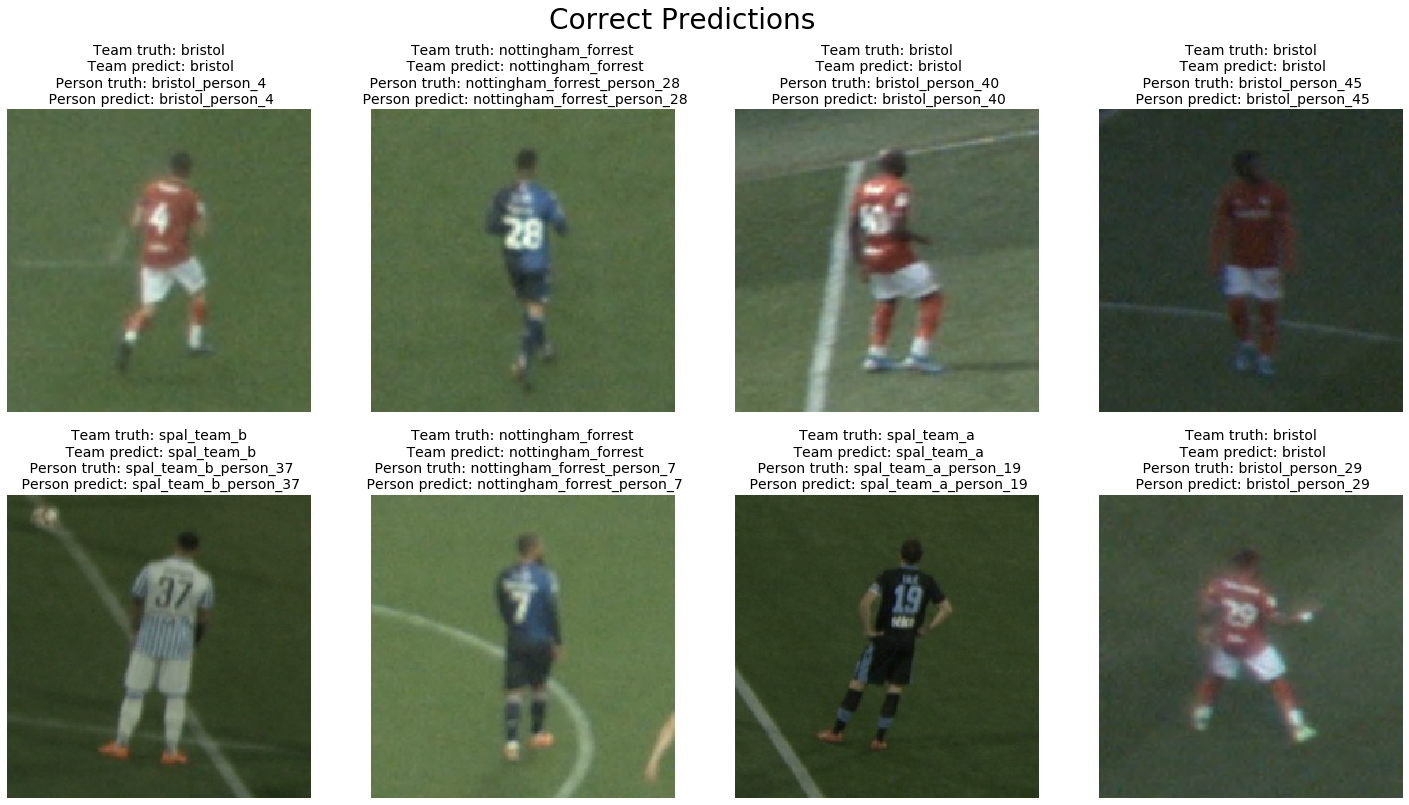

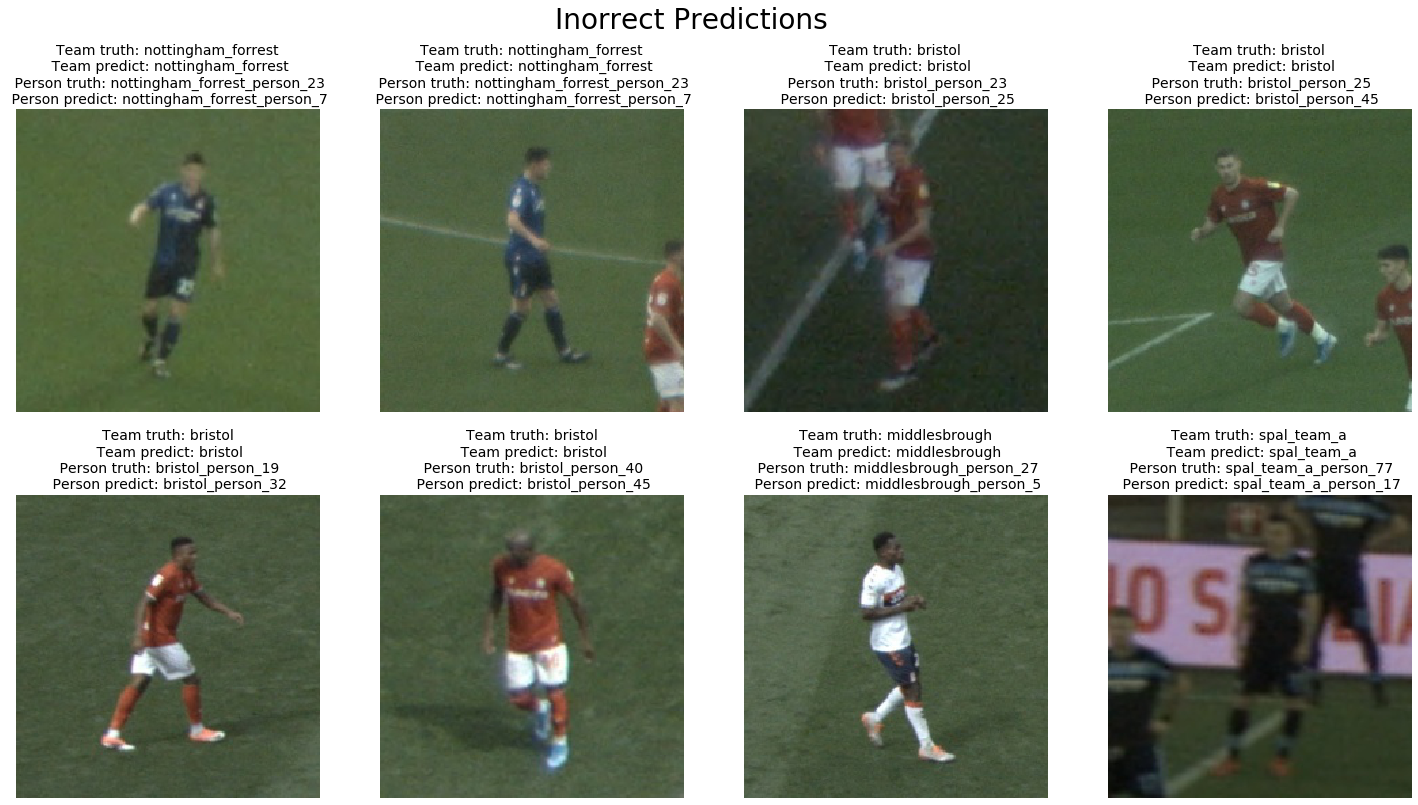

In [19]:
# plot some correct predictions
plot_tiles(idx_to_plot_correct,nrows=2,ncols=4,suptitle='Correct Predictions')
# plot some incorrect predictions
plot_tiles(idx_to_plot_incorrect,nrows=2,ncols=4,suptitle='Inorrect Predictions')

# SAVE MODEL

In [17]:
# SAVING MODEL
# get example input from test set
example_im = torch.zeros(1, 3, 224, 224)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example_im)

# test output
output = traced_script_module(example_im)
print(output)

# save model
traced_script_module.save("team_and_person_model.pt")

(tensor([[-1.0054, -0.0347, -1.9655,  0.6942,  1.3998,  0.3958]],
       grad_fn=<AddBackward0>), tensor([[ 0.3295,  0.5060,  0.3000,  0.3007, -2.2367,  0.9437,  0.2431, -0.3105,
         -0.8001, -0.3623, -1.0943,  1.3745,  0.0186, -1.1518, -1.0468, -0.4075,
          0.1533, -1.1407, -1.0912,  0.2528, -0.0801,  0.0164, -0.7735, -0.6710,
          0.3230, -1.5582,  0.4918,  0.5308, -1.2764, -1.8148,  0.8784, -0.3968,
          0.1182,  0.3966, -0.1566, -1.7660, -0.9979, -0.3426, -0.8097, -0.2651,
          0.1499,  1.3768, -2.8483, -0.8546, -0.8076,  1.4347,  0.1707,  0.0241,
          0.5739, -0.9535, -0.4659, -1.5382,  1.3120, -0.3606]],
       grad_fn=<AddBackward0>))
